# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services
In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [129]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gower

from prince import MCA
import prince
from sklearn.cluster import KMeans
from sklearn import datasets, cluster
from sklearn.cluster import DBSCAN
from sklearn import random_projection
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import warnings

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data
There are four data files associated with this project:

- Udacity_AZDIAS_052018.csv: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- Udacity_CUSTOMERS_052018.csv: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- Udacity_MAILOUT_052018_TRAIN.csv: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- Udacity_MAILOUT_052018_TEST.csv: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.


In [228]:
# load in the data
#azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', low_memory = False)
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory = False)

In [229]:
def defining_types(dataset):
    """ 
    Input: dataset - the columns of this dataset are taken
    Output: c_all - all columns we use in the dataset
            c_num/c_ord/c_cat - numeric, ordinal and categorical columns
            kba_semio - is needed for setting unknowns to a common value
    """
    all_cols = set(dataset.columns)

    drop_cols = {'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

    for element in drop_cols:
        all_cols.discard(element)

    c_num = {'ALTER_HH','ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','GEBURTSJAHR','MIN_GEBAEUDEJAHR','KBA13_ANZAHL_PKW'}

    c_cat = {'AGER_TYP','ANREDE_KZ','CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015','CJT_GESAMTTYP','D19_KONSUMTYP',
            'KK_KUNDENTYP','FINANZTYP','GEBAEUDETYP','GFK_URLAUBERTYP','GREEN_AVANTGARDE','HEALTH_TYP',
            'KBA05_BAUMAX','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','LP_STATUS_FEIN',
            'LP_STATUS_GROB','NATIONALITAET_KZ','OST_WEST_KZ','PLZ8_BAUMAX','PRAEGENDE_JUGENDJAHRE','REGIOTYP','RETOURTYP_BK_S',
            'SHOPPER_TYP','SOHO_KZ','TITEL_KZ','VERS_TYP','WOHNLAGE','ZABEOTYP'}

    c_ord = {'ALTERSKATEGORIE_GROB','BALLRAUM','D19_BANKEN_ANZ_12','D19_BANKEN_ANZ_24','D19_BANKEN_DATUM','D19_BANKEN_DIREKT',
            'D19_BANKEN_GROSS','D19_BANKEN_LOKAL','D19_BANKEN_OFFLINE_DATUM','D19_BANKEN_ONLINE_DATUM','D19_BANKEN_ONLINE_QUOTE_12',
            'D19_BANKEN_REST','D19_BEKLEIDUNG_GEH','D19_BEKLEIDUNG_REST','D19_BILDUNG','D19_BIO_OEKO','D19_BUCH_CD','D19_DIGIT_SERV',
            'D19_DROGERIEARTIKEL','D19_ENERGIE','D19_FREIZEIT','D19_GARTEN','D19_GESAMT_ANZ_12','D19_GESAMT_ANZ_24','D19_GESAMT_DATUM',
            'D19_GESAMT_OFFLINE_DATUM','D19_GESAMT_ONLINE_DATUM','D19_GESAMT_ONLINE_QUOTE_12','D19_HANDWERK','D19_HAUS_DEKO',
            'D19_KINDERARTIKEL','D19_KOSMETIK','D19_LEBENSMITTEL','D19_LOTTO','D19_NAHRUNGSERGAENZUNG','D19_RATGEBER','D19_REISEN',
            'D19_SAMMELARTIKEL','D19_SCHUHE','D19_SONSTIGE','D19_TECHNIK','D19_TELKO_ANZ_12','D19_TELKO_ANZ_24','D19_TELKO_DATUM',
            'D19_TELKO_MOBILE','D19_TELKO_OFFLINE_DATUM','D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST','D19_TIERARTIKEL','D19_VERSAND_ANZ_12',
            'D19_VERSAND_ANZ_24','D19_VERSAND_DATUM','D19_VERSAND_OFFLINE_DATUM','D19_VERSAND_ONLINE_DATUM','D19_VERSAND_ONLINE_QUOTE_12',
            'D19_VERSAND_REST','D19_VERSICHERUNGEN','D19_VERSI_ANZ_12','D19_VERSI_ANZ_24','D19_VOLLSORTIMENT','D19_WEIN_FEINKOST',
            'EWDICHTE','FINANZ_ANLEGER','FINANZ_HAUSBAUER','FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_UNAUFFAELLIGER','FINANZ_VORSORGER',
            'GEBAEUDETYP_RASTER','HH_EINKOMMEN_SCORE','INNENSTADT','KKK','KONSUMNAEHE','MOBI_REGIO','ONLINE_AFFINITAET',
            'ORTSGR_KLS9','PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4','PLZ8_GBZ','PLZ8_HHZ','RELAT_AB','WOHNDAUER_2008',
            'W_KEIT_KIND_HH'}

    #variables in excel but not in customers: 'GEOSCORE_KLS7', 'WACHSTUMSGEBIET_NB', 'BIP_FLAG', 'HAUSHALTSSTRUKTUR'

    remainer = all_cols - c_num - c_cat - c_ord

    # Lots of variables start with KBA and SEMIO and have a ordinal structure. 
    kba_semio = {s for s in remainer if 'KBA' in s or 'SEMIO_' in s}
    c_ord = c_ord.union(kba_semio)

    # No match in the xlsx but they look similar to other ordinal columns. 
    c_ord.update(['D19_SOZIALES', 'D19_VERSI_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12'])

    # EINGEZOGENAM_HH_JAHR looks numeric
    c_num.add('EINGEZOGENAM_HH_JAHR')

    # All other columns are treated as categorical if they have unique values <= 10. 
    remainer = all_cols - c_num - c_cat - c_ord
    u_counts = dataset[list(remainer)].nunique()
    c_cat_2 = set(u_counts[u_counts <= 10].index)
    c_cat = c_cat.union(c_cat_2)

    remainer = all_cols - c_num - c_cat - c_ord
    print('We will remove {} variables.'.format(len(remainer)))
    print(remainer)

    c_all = c_num | c_cat | c_ord 
    
    return c_all, c_num, c_cat, c_ord, kba_semio



In [3]:
def data_preprocessing(daten, c_all, kba_semio):
    """
    Input: daten - for which we replace values
           c_all - all columns we use in the dataset
           kba_semio - for these variables unknowns are also in 9
           
    Output: daten - but with unknowns to nan and sometimes the minimum was moved from 0 to 8. 
    """
    pd.options.mode.chained_assignment = None  # default='warn'
    # We drop all columns which are not in c_all. 
    daten = daten[list(c_all)]

    # NA und unknown values are sometimes -1, 0 and 9. 
    # We define -1 for all as NA.
    unknown_0 = ['ANREDE_KZ','GEBAEUDETYP','HEALTH_TYP','HH_EINKOMMEN_SCORE','KBA05_BAUMAX','KKK','NATIONALITAET_KZ','ALTERSKATEGORIE_GROB',
                'PRAEGENDE_JUGENDJAHRE','REGIOTYP','TITEL_KZ','WOHNDAUER_2008','WOHNLAGE','W_KEIT_KIND_HH','CJT_GESAMTTYP','RETOURTYP_BK_S']
    daten.loc[:, unknown_0] = daten.loc[:, unknown_0].replace(0, np.nan)

    unknown_9 = ['RELAT_AB','ZABEOTYP'] + list(kba_semio)
    daten.loc[:, unknown_9] = daten.loc[:, unknown_9].replace(9, np.nan)

    # Some of the ordinal columns have the order 7 (min) to 1 (max), but 0 for none. We hav to change 0 to 8. 
    min_0 = ['D19_BANKEN_DIREKT','D19_BANKEN_GROSS','D19_BANKEN_LOKAL','D19_BANKEN_REST','D19_BEKLEIDUNG_GEH','D19_BEKLEIDUNG_REST','D19_BILDUNG',
            'D19_BIO_OEKO','D19_BUCH_CD','D19_DIGIT_SERV','D19_DROGERIEARTIKEL','D19_ENERGIE','D19_FREIZEIT','D19_GARTEN','D19_HANDWERK','D19_HAUS_DEKO',
            'D19_KINDERARTIKEL','D19_KOSMETIK','D19_LEBENSMITTEL','D19_LOTTO','D19_NAHRUNGSERGAENZUNG','D19_RATGEBER','D19_REISEN','D19_SAMMELARTIKEL',
            'D19_SCHUHE','D19_SONSTIGE','D19_TECHNIK','D19_TELKO_MOBILE','D19_TELKO_REST','D19_TIERARTIKEL','D19_VERSAND_REST','D19_VERSICHERUNGEN',
            'D19_VERSI_ANZ_12','D19_VERSI_ANZ_24','D19_VOLLSORTIMENT','D19_WEIN_FEINKOST','D19_SOZIALES']

    daten.loc[:, min_0] = daten.loc[:, min_0].replace(0, 8)

    # We set -1 to na because this simplifies operations later.
    daten = daten.replace(-1, np.nan)

    return daten

def export_na(dataset, columns, out_name):
    """ 
    Input:
    dataset - file to export
    columns - columns to export
    out_name - the output name
    
    Output: 
    csv-file

    Shows the share of missing values for the mentioned columns in the dataset. 
    """
    q = dataset[list(columns)].isna().mean().sort_values(ascending = False)
    file_path = '{}.csv'.format(out_name)
    q.to_csv(file_path)
    pass

def dropping_rows(dataset, threshold):
    """
    Input:
    dataset - dataset we check
    threshold - if this threshold is exceeded we drop the row

    Output:
    dataset - without the rows with too many missings
    """
    print('Before:', dataset.shape[0])
    dataset = dataset.dropna(axis = 0, thresh = (1 - threshold) * len(dataset.columns))
    print('After:', dataset.shape[0])
    return dataset


def dropping_columns(daten, threshold = 0.4):
    """
    Input: 
    daten - dataset we check 
    threshold - if this threshold is exceeded we drop the column

    We also drop some variables for which we have bigger groups. 

    Output:
    dataset - without the columns with too many missings.
    """
    print('Before:', daten.shape[1])
    pd.options.mode.chained_assignment = None  # default='warn'
    
    # We drop these variables because we have similar ones with less categories
    feature_drop = {'CAMEO_INTL_2015','CAMEO_DEU_2015','LP_LEBENSPHASE_FEIN','LP_STATUS_FEIN','LP_FAMILIE_FEIN','ALTERSKATEGORIE_GROB','MIN_GEBAEUDEJAHR'}
    fd_candidates = list(feature_drop.intersection(set(daten.columns)))
    daten.drop(columns = fd_candidates, inplace = True)

    # We drop these variables because they have too many missings. 
    missings = daten.isna().mean() 
    c_drop = missings[missings > threshold].index
    print('We drop {} variables because of too many missings.'.format(len(c_drop)))
    print(c_drop)
    daten.drop(columns = c_drop, inplace = True)

    print('After:', daten.shape[1])

    return daten

# Filling na:
def filling_na(datenset):
    """
    Input:
    datenset - the dataset for which we fill na. 

    Output:
    datenset - with missing values filled with mean, mode or unknown category. 
    """
    datenset_columns = set(datenset.columns)
    
    # We fill numeric columns with the mean
    fill_num = list(c_num.intersection(datenset_columns))
    datenset[fill_num] = datenset[fill_num].fillna(datenset[fill_num].mean())

    # We fill ordinal columns with the mode
    fill_ord = list(c_ord.intersection(datenset_columns))
    datenset[fill_ord] = datenset[fill_ord].fillna(datenset[fill_ord].mode().iloc[0])

    # We fill categorical columns with the unknown category.
    fill_cat = list(c_cat.intersection(datenset_columns))
    datenset[fill_cat] = datenset[fill_cat].fillna('-1')
    return datenset

# Set the data types for numeric, ordinal and categorical columns.
def setting_types(daten):
    """
    Input: daten - for which we set the column types
    Output: daten - with column types set. 
    """
    datenset_columns = set(daten.columns)
    num = list(c_num.intersection(datenset_columns))
    ord = list(c_ord.intersection(datenset_columns))
    cat = list(c_cat.intersection(datenset_columns))

    data_types = {col: 'object' for col in list(cat)}
    data_types.update({col: 'float' for col in list(num)})
    data_types.update({col: 'float' for col in list(ord)})
    daten = daten.astype(data_types)

    return daten


def descriptive_stats(dataset, column_type, output_name):
    """
    Input: 
    dataset - dataset to be analysed
    column_type - either c_num or c_ord
    output_name - name of file

    Description:
    Creating and exporting descriptive statistics 
    """

    # Identifiying data extremes in numerics
    columns = list(column_type.intersection(dataset.columns))
    quantiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
    describe_summary = dataset[columns].describe(percentiles=quantiles)

    # Specify the filename
    filename = '{}_describe_summary.csv'.format(output_name)
    describe_summary.to_csv(filename)

    pass

def search_and_correct(dataset):
    
    # Correcting data extremes in numerics.
    
    quantile_99 = dataset[['ANZ_PERSONEN','GEBURTSJAHR','ANZ_HH_TITEL']].quantile(0.99)
    quantile_95 = dataset['ANZ_HAUSHALTE_AKTIV'].quantile(0.95)
    dataset[['ANZ_PERSONEN','GEBURTSJAHR','ANZ_HH_TITEL']] = dataset[['ANZ_PERSONEN','GEBURTSJAHR','ANZ_HH_TITEL']].clip(upper=quantile_99, axis=1)
    dataset['ANZ_HAUSHALTE_AKTIV'] = dataset['ANZ_HAUSHALTE_AKTIV'].clip(upper=quantile_95)


    mean_GEBURTSJAHR = int(np.mean(dataset.loc[dataset['GEBURTSJAHR'] > 1900, 'GEBURTSJAHR']))
    dataset.loc[dataset['GEBURTSJAHR'] <= 1900, 'GEBURTSJAHR'] = mean_GEBURTSJAHR
    dataset[['ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN']] = dataset[['ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN']].replace(0, 1)

    return dataset

def exporting(daten, filename):

    # Export the DataFrame to a CSV file
    daten.to_csv(filename, index=False)


In [230]:

all_cols, c_num, c_cat, c_ord, kba_semio = defining_types(customers)
customers = data_preprocessing(customers, all_cols, kba_semio)

We will remove 13 variables.
{'EINGEFUEGT_AM', 'ALTER_KIND2', 'LNR', 'EXTSEL992', 'VK_DHT4A', 'ALTER_KIND3', 'ALTER_KIND1', 'D19_LETZTER_KAUF_BRANCHE', 'ALTERSKATEGORIE_FEIN', 'ANZ_STATISTISCHE_HAUSHALTE', 'VK_ZG11', 'VERDICHTUNGSRAUM', 'VK_DISTANZ'}


In [246]:
customers.isna().mean().sort_values(ascending = False)

ALTER_KIND4                  0.998769
TITEL_KZ                     0.987936
KK_KUNDENTYP                 0.584064
KBA05_BAUMAX                 0.571531
AGER_TYP                     0.480595
                               ...   
ALTERSKATEGORIE_GROB         0.000000
D19_TELKO_REST               0.000000
D19_BIO_OEKO                 0.000000
D19_VERSAND_OFFLINE_DATUM    0.000000
D19_BANKEN_ANZ_12            0.000000
Length: 353, dtype: float64

In [244]:

""" 
# This is too crowdy.


# Calculate the number of missing values in each column
missing_counts = df.isnull().sum()
# Filter out columns with no missing values
missing_counts_filtered = missing_counts[missing_counts > 0]
# Sort columns by the number of missing values (descending order)
missing_counts_sorted = missing_counts_filtered.sort_values(ascending=False)

# Create the bar chart
plt.figure(figsize=(6, 14))
plt.barh(missing_counts_sorted.index, missing_counts_sorted.values)
plt.xlabel('Number of Missing Values', fontsize=12)
plt.ylabel('Columns')
plt.yticks(fontsize = 6)
plt.title('Missing Values by Column')
plt.gca().invert_yaxis()  # Invert y-axis to show the column with the most missing values at the top
plt.tight_layout()

# Show the plot
plt.show()

"""

" \n# This is too crowdy.\n\n\n# Calculate the number of missing values in each column\nmissing_counts = df.isnull().sum()\n# Filter out columns with no missing values\nmissing_counts_filtered = missing_counts[missing_counts > 0]\n# Sort columns by the number of missing values (descending order)\nmissing_counts_sorted = missing_counts_filtered.sort_values(ascending=False)\n\n# Create the bar chart\nplt.figure(figsize=(6, 14))\nplt.barh(missing_counts_sorted.index, missing_counts_sorted.values)\nplt.xlabel('Number of Missing Values', fontsize=12)\nplt.ylabel('Columns')\nplt.yticks(fontsize = 6)\nplt.title('Missing Values by Column')\nplt.gca().invert_yaxis()  # Invert y-axis to show the column with the most missing values at the top\nplt.tight_layout()\n\n# Show the plot\nplt.show()\n\n"

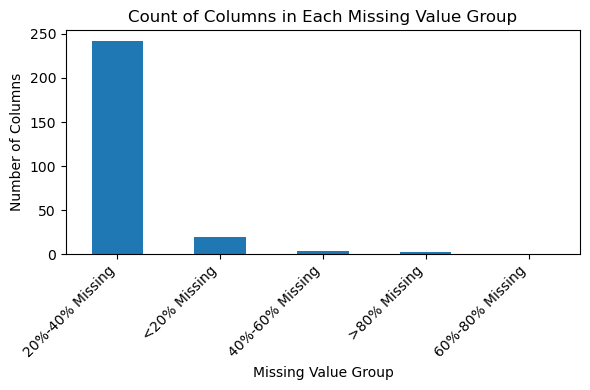

In [257]:
df = customers

# Calculate the percentage of missing values in each column
missing_percentage = df.isna().mean()*100

# Define the bins for grouping columns based on missing value percentages
bins = [0,20,40,60,80,100]
labels = ['<20% Missing', '20%-40% Missing', '40%-60% Missing', '60%-80% Missing', '>80% Missing']

# Categorize the columns based on the bins
group_labels = pd.cut(missing_percentage, bins=bins, labels=labels)

# Create a new DataFrame to hold the information
grouped_df = pd.DataFrame({'Column Name': df.columns, 'Missing Percentage': missing_percentage, 'Group': group_labels})

# Count the number of columns in each group
group_counts = grouped_df['Group'].value_counts()

# Create the bar chart
plt.figure(figsize=(6, 4))
group_counts.plot(kind='bar')
plt.xlabel('Missing Value Group')
plt.ylabel('Number of Columns')
plt.title('Count of Columns in Each Missing Value Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [258]:

all_cols, c_num, c_cat, c_ord, kba_semio = defining_types(customers)
customers = data_preprocessing(customers, all_cols, kba_semio)

#export_na(dataset = customers, columns = c_ord, out_name = 'c_ord_missings')
#export_na(dataset = customers, columns = c_num, out_name = 'c_num_missings')
#export_na(dataset = customers, columns = c_cat, out_name = 'c_cat_missings')

customers = dropping_rows(dataset = customers, threshold = 0.40)
# only 140854 rows remain if we set threshold to 0.4
customers = dropping_columns(daten = customers) 
#only 103 columns would remain if we set threshold to 0.2

customers = filling_na(customers)
customers = setting_types(daten = customers)

We will remove 0 variables.
set()
Before: 191652
After: 140854
Before: 353
We drop 4 variables because of too many missings.
Index(['KK_KUNDENTYP', 'ALTER_KIND4', 'KBA05_BAUMAX', 'TITEL_KZ'], dtype='object')
After: 342


In [ ]:
azdias = data_preprocessing(azdias, all_cols, kba_semio)
azdias = dropping_rows(dataset = azdias, threshold = 0.40)
# roughly 100,000 obs dropped
azdias = dropping_columns(daten = azdias)
# 341 variables remain
azdias = filling_na(azdias)
azdias = setting_types(daten = azdias)

In [85]:

descriptive_stats(dataset = azdias, column_type = c_num, output_name = 'azdias_numeric')
descriptive_stats(dataset = azdias, column_type = c_ord, output_name = 'azdias_ordinal')
azdias = search_and_correct(dataset = azdias)
exporting(azdias, 'data/azdias_new.csv')

In [37]:

descriptive_stats(dataset = customers, column_type = c_num, output_name = 'numeric')
descriptive_stats(dataset = customers, column_type = c_ord, output_name = 'ordinal')
customers = search_and_correct(dataset = customers)
exporting(customers, 'data/custom_new.csv')

8


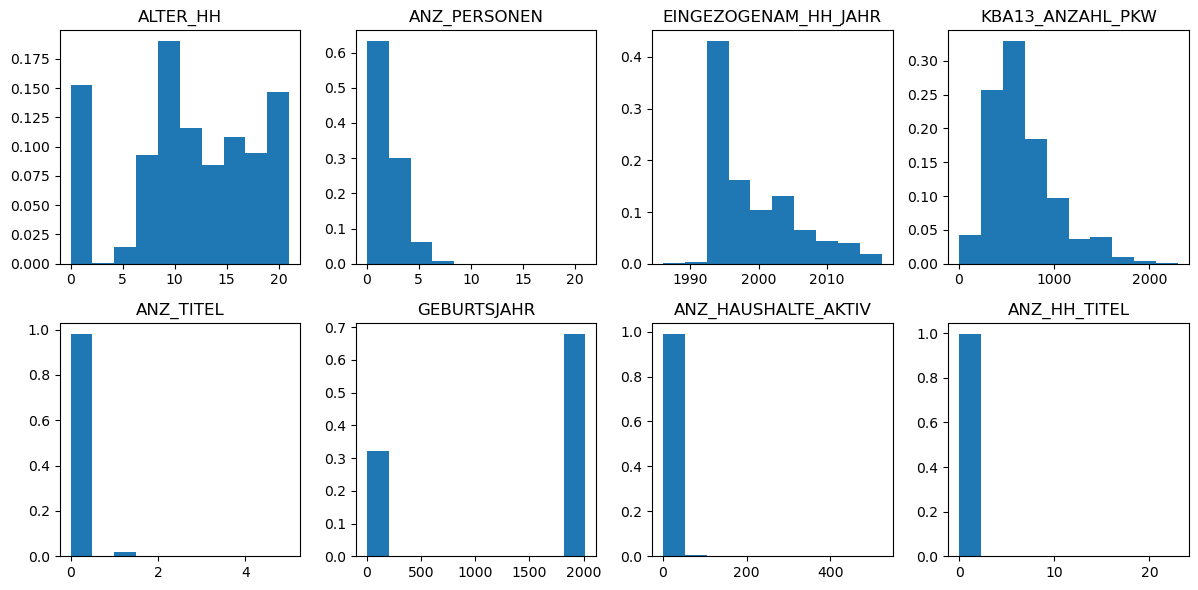

In [259]:
# Calculate the dimensions of the subplots based on the number of columns
dataset = customers

columns = list(c_num.intersection(dataset.columns))
num_columns = len(columns)
print(num_columns)
num_rows = 3
if num_columns > 4:
    num_rows = num_columns // 5 + (num_columns % 5 > 0)

# Create the subplots
fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3 * num_rows))

# Flatten the axes if necessary
if num_rows > 1:
    axes = axes.flatten()

# Iterate over the columns and create the bin charts
for i, col in enumerate(columns):
    ax = axes[i]
    # from https://stackoverflow.com/questions/9767241/setting-a-relative-frequency-in-a-matplotlib-histogram
    n, bins, _  = ax.hist(dataset[col], weights=np.zeros_like(dataset[col]) + 1. / dataset[col].size)
    ax.set_title(col)

fig.tight_layout()
plt.savefig('num_graph.png')
plt.show()

## Part 1: Customer Segmentation Report
The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Functions

In [184]:
def standardizing_numeric(dataset):
    """
    Input: dataset (only numeric columns!)
    Output: dataset

    Description:
    The column values are standardized so they have mean 0 and standard deviation of 1. 
    """
    #https://stackoverflow.com/questions/26414913/normalize-columns-of-a-dataframe
    dataset=(dataset-dataset.mean())/dataset.std()
    return dataset

def standardize_ordinal(dataset):
    """
    Input: dataset (only ordinal columns!)
    Output: dataset

    Description:
    The column values are changes according to current literature
    """
    # from The Elements of Statistical Learning by Trevor Hastie, Robert Tibshirani, Jerome Friedman, p.504
    for c in dataset.columns:
        c_max = dataset[c].max()
        dataset[c] = (dataset[c] - 0.5) / c_max
    return dataset

def drawing_sample(input, output_name, size):
    """
    input: Dataset from which we draw a sample.
    output_name: The name of the exported file. 
    size: Relative size (between 0 and 1). 

    Description:
    We draw a sample from the dataset and export it. 
    """
    sample_size = int(len(input) * size)
    #output = input.sample(n=sample_size, random_state = 17)
    output = input.sample(n=20000, random_state = 17)
    exporting(output, 'data/{}.csv'.format(output_name))
    return output

def pca_model(data, components):
    """
    Input: 
    data: dataset for which we want to do pca
    components: number of components

    Output:
    my_model, my_model_fit, var_explained

    Description:
    We reduce the dimension of the data by performing pca. The user can define the n_components. 
    Do it for numeric/ordinal variables.
    """
    # From https://stackoverflow.com/questions/32857029/python-scikit-learn-pca-explained-variance-ratio-cutoff
    my_model = PCA(n_components=components)
    my_model_fit = my_model.fit_transform(data)
    var_explained = np.fromstring(str(my_model.explained_variance_ratio_.cumsum())[1:-1], sep=' ')
    return my_model, my_model_fit, var_explained

def mca_model(data):
    """
    Input: data we want to do mca
    Output: new_data, my_model

    Description:
    We reduce the dimension of the data by performing mca. Do it for categorical variables. 
    """
    # From https://stackoverflow.com/questions/32857029/python-scikit-learn-pca-explained-variance-ratio-cutoff
    my_model = MCA()
    my_model.fit(data)
    new_data = my_model.transform(data)
    return new_data, my_model

def elbow_method(data, max_clusters):
    """
    Input:
    data: the dataset we want to search for clusters
    max_clusters: the maximum number of clusters

    Output: None

    Description:
    We increase the number of clusters from 1 to max_clusters and calculated the inertia_values.
    We plot the inertia_values so we see how it develops as the number of clusters increases. 
    """
    #https://predictivehacks.com/k-means-elbow-method-code-for-python/
    inertia_values = []

    for num_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)

    # Plotting the Elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), inertia_values, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xticks(np.arange(1, max_clusters + 1, 1))
    plt.grid(True)
    plt.show()

def cluster_kmeans(data, num_clusters):
    """
    data: The data in which we look for clusters.
    num_clusters: How many clusters we want.
    
    Description:
    Clusters are identified and a cluster column is added to the DF. 
    A summary of how the clusters are populated is printed. 
    """

    kmeans = KMeans(n_clusters=num_clusters)
    cluster_assignments = kmeans.fit_predict(data)
    data['Cluster'] = cluster_assignments
    print(np.unique(cluster_assignments, return_counts = True))

    pass 

def dbscan_clustering(data, eps = 0.5, min_samples = 5):
    """
    Input:
    data: data used for clustering
    eps: key parameter in clustering 
    min-samples: key parameter in clustering
    
    Output:
    Adds the cluster assignments as a new column to data
    Prints the number of clusters found

    Description:
    Uses DBSCAN to find clusters. 
    """
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_assignments = dbscan.fit_predict(data)
    data['Cluster'] = cluster_assignments
    num_clusters = len(np.unique(cluster_assignments)) - 1
    print(f"Number of clusters found: {num_clusters}")
    print(data['Cluster'].value_counts())

def DBSCAN_plotting(data, eps, min_samples):
    """
    data: data used for clustering
    eps: key parameter in clustering 
    min_samples: key parameter in clustering

    Description:
    Adds the cluster assignments as a new column to data.
    Plots the clusters. Only use it when the dimension is 2. 
    """
    
    #https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
    
    # Initialize and fit DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples)
    #db.fit(data)
    cluster_assignments = db.fit_predict(data)
    data['Cluster'] = cluster_assignments
    print(data['Cluster'].value_counts())
    
    # Create a scatter plot for the clusters
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    # Plot the points
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = data[class_member_mask & core_samples_mask].values
        plt.plot(xy[:, 0], xy[:, 1], 'o', markeredgecolor='k', markersize=6)

        xy = data[class_member_mask & ~core_samples_mask].values
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=4)

    plt.title(f'Estimated number of clusters: {n_clusters_}')
    plt.show()

def clusters_to_dataset(target_df, cluster_df, cluster_column, cust):
    """
    target_df: name of the DF you would like to add the cluster. 
    cluster_df: name of the DF containing the cluster column.
    cluster_column: name of the cluster column.
    cust: boolean, if 1 the second part of the dataset is taken. Put 1 if you want customers, 0 if you want azdias.

    Description:
    Adds the cluster to the original dataset. 
    """
    if cust == True:
        series_cluster = cluster_df[cluster_column].iloc[len(small_azdias):].reset_index()
    else:
        series_cluster = cluster_df[cluster_column].iloc[0:len(small_azdias)].reset_index()
    output_df = target_df.reset_index()
    output_df = pd.concat([output_df, series_cluster], axis = 1)
    print(target_df.shape)
    output_df.shape
    return output_df

def cluster_stats(dataset, name, column):
    """
    dataset: the dataset we do the stats. 
    name: extra name for the output file.
    column: the column over which stats are reported.

    Description:
    Calculated some statistics over the column, grouped by the cluster. Recommended for datasets with few clusters. 
    """
    relativ = dataset.groupby(by = 'Cluster')[column].value_counts(normalize=True).sort_index()
    abs = dataset.groupby(by = 'Cluster')[column].value_counts().sort_index()
    stats = pd.concat([abs, relativ], axis=1)
    stats.columns = ['Absolute_Count', 'Relative_Value']
    stats.to_csv('output/cluster_stats_{}_{}.txt'.format(name, column), sep='\t')
    return print(stats)


def cluster_mean(dataset, name, column):
    """
    dataset: the dataset we do the stats. 
    name: extra name for the output file.
    column: the column over which stats are reported.
    
    Description
    Calculated the mean over the column, grouped by the cluster. Recommended for datasets with many clusters. 
    """
    meanc = dataset.groupby(by = 'Cluster')[column].mean()
    meanc.to_csv('output/cluster_mean_{}_{}.txt'.format(name, column), sep='\t')
    return print(meanc)

### Part 1.0a Preparing data
Involves standardizing and drawing a sample. 

In [5]:
# Only necessary if the small dataset are not yet available! 
customers = pd.read_csv('data/custom_new.csv', sep=',')
c_all, c_num, c_cat, c_ord, kba_semio = defining_types(customers)
customers = setting_types(daten = customers)
azdias = pd.read_csv('data/azdias_new.csv', sep=',', low_memory = False)
azdias = setting_types(daten = azdias)

C:\Users\TAMM\AppData\Local\Temp\ipykernel_10248\1544280073.py:2: DtypeWarning: Columns (172) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('data/custom_new.csv', sep=',')


We will remove 0 variables.
set()


In [7]:
num_cols = list(c_num.intersection(azdias.columns))
azdias[num_cols] = standardizing_numeric(azdias[num_cols])
ord_cols = list(c_ord.intersection(azdias.columns))
azdias[ord_cols] = standardize_ordinal(dataset = azdias[ord_cols])

C:\Users\TAMM\AppData\Local\Temp\ipykernel_10248\3849038417.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[c] = (dataset[c] - 0.5) / c_max


In [8]:
num_cols = list(c_num.intersection(customers.columns))
customers[num_cols] = standardizing_numeric(customers[num_cols])
ord_cols = list(c_ord.intersection(customers.columns))
customers[ord_cols] = standardize_ordinal(dataset = customers[ord_cols])

C:\Users\TAMM\AppData\Local\Temp\ipykernel_10248\3849038417.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[c] = (dataset[c] - 0.5) / c_max


In [10]:
small_customers = drawing_sample(input = customers, output_name = 'small_custom_20k', size = 0.15)
small_azdias = drawing_sample(input = azdias, output_name = 'small_azdias_20k', size = 0.05)

In [11]:
customers_num = small_customers.select_dtypes(include=['float'])
customers_obj = small_customers.select_dtypes(include=['object'])
print(' Total:', small_customers.shape, '\n', 'Numeric:', customers_num.shape, '\n', 'Categorical:', customers_obj.shape)

azdias_num = small_azdias.select_dtypes(include=['float'])
azdias_obj = small_azdias.select_dtypes(include=['object'])
print(' Total:', small_azdias.shape, '\n', 'Numeric:', azdias_num.shape, '\n', 'Categorical:', azdias_obj.shape)

 Total: (20000, 342) 
 Numeric: (20000, 291) 
 Categorical: (20000, 51)
 Total: (20000, 341) 
 Numeric: (20000, 291) 
 Categorical: (20000, 50)


### Part 1.0b Importing small dataset

In [93]:
# Importing small customer dataset
small_customers = pd.read_csv('data/small_custom.csv', sep=',')
c_all, c_num, c_cat, c_ord, kba_semio = defining_types(small_customers)
small_customers = setting_types(daten = small_customers)
print(small_customers.shape)

customers_num = small_customers.select_dtypes(include=['float'])
customers_obj = small_customers.select_dtypes(include=['object'])
print(' Total:', small_customers.shape, '\n', 'Numeric:', customers_num.shape, '\n', 'Categorical:', customers_obj.shape)

C:\Users\TAMM\AppData\Local\Temp\ipykernel_10248\3321245273.py:2: DtypeWarning: Columns (172) have mixed types. Specify dtype option on import or set low_memory=False.
  small_customers = pd.read_csv('data/small_custom.csv', sep=',')


We will remove 0 variables.
set()
(21128, 342)
 Total: (21128, 342) 
 Numeric: (21128, 291) 
 Categorical: (21128, 51)


In [94]:
# Importing small azdias dataset
small_azdias = pd.read_csv('data/azdias_small.csv', sep=',')
c_all, c_num, c_cat, c_ord, kba_semio = defining_types(small_azdias)
small_azdias = setting_types(daten = small_azdias)

azdias_num = small_azdias.select_dtypes(include=['float'])
azdias_obj = small_azdias.select_dtypes(include=['object'])
print(' Total:', small_azdias.shape, '\n', 'Numeric:', azdias_num.shape, '\n', 'Categorical:', azdias_obj.shape)

C:\Users\TAMM\AppData\Local\Temp\ipykernel_10248\1371092585.py:2: DtypeWarning: Columns (278) have mixed types. Specify dtype option on import or set low_memory=False.
  small_azdias = pd.read_csv('data/azdias_small.csv', sep=',')


We will remove 0 variables.
set()
 Total: (39555, 341) 
 Numeric: (39555, 291) 
 Categorical: (39555, 50)


### 1.1 Reducing dimensions

In [95]:
# Customers: Run pca and mca
print(customers_num.shape)
cust_model, cust_model_fit, cust_var_expl = pca_model(data = customers_num, components = 50)
print(cust_var_expl)
new_cust_num = pd.DataFrame(cust_model.transform(customers_num))

# initially I went with 50 (explaining 78% of variance), but I could not find sensible clusters then. 
# trying with 10 (explaining 50%)
# back with n = 50... 

new_cust_obj, cust_mca_model = mca_model(customers_obj)
new_cust_obj.shape


(21128, 291)
[0.11385283 0.19437199 0.26939884 0.32179454 0.36641877 0.40893959
 0.44019954 0.46808757 0.48883188 0.50860305 0.5251022  0.54009588
 0.55413838 0.56807608 0.58075892 0.59224434 0.60270508 0.61265688
 0.62189821 0.63043068 0.63814699 0.645717   0.65321491 0.66001322
 0.66641358 0.67261699 0.67855653 0.6843374  0.68991108 0.69538821
 0.70074223 0.70595954 0.71095318 0.71580428 0.72059214 0.72525298
 0.72979302 0.73425154 0.73855416 0.74278788 0.74696587 0.75092096
 0.75475181 0.75853221 0.76222732 0.76580272 0.76922201 0.77256933
 0.77588204 0.77909681]


c:\Users\TAMM\anaconda3\lib\site-packages\prince\mca.py:30: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = pd.get_dummies(X, columns=X.columns)
c:\Users\TAMM\anaconda3\lib\site-packages\prince\mca.py:30: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = pd.get_dummies(X, columns=X.columns)
c:\Users\TAMM\anaconda3\lib\site-packages\prince\mca.py:30: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = pd.get_dummies(X, columns=X.columns)
c:\Users\TAMM\anaconda3\lib\site-packages\prince\mca.py:30: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = p

(21128, 2)

In [8]:

# Azdias: Run pca and mca
azdi_model, azdi_model_fit, azdi_var_expl = pca_model(data = azdias_num, components = 50)
print(azdi_var_expl)
new_azdi_num = pd.DataFrame(azdi_model.transform(azdias_num))

new_azdi_obj, azdi_mca_model = mca_model(azdias_obj)
new_azdi_obj.shape

[0.10485926 0.18405031 0.24164315 0.29573595 0.33873573 0.377579
 0.4137317  0.44640093 0.47367173 0.49741473 0.51849643 0.53671761
 0.55411087 0.56969281 0.58372578 0.59540485 0.60651043 0.61674152
 0.6265872  0.63553611 0.64327788 0.65083494 0.65833197 0.66577948
 0.67250673 0.67893794 0.6847294  0.69049331 0.69603847 0.70138301
 0.70661906 0.71175527 0.71678764 0.7216283  0.72637811 0.73095761
 0.73541817 0.73983496 0.74413004 0.74836092 0.75256342 0.75650921
 0.76035176 0.764103   0.76779511 0.7713858  0.7749397  0.7783629
 0.78173969 0.78506839]


c:\Users\TAMM\anaconda3\lib\site-packages\prince\mca.py:30: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = pd.get_dummies(X, columns=X.columns)
c:\Users\TAMM\anaconda3\lib\site-packages\prince\mca.py:30: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = pd.get_dummies(X, columns=X.columns)
c:\Users\TAMM\anaconda3\lib\site-packages\prince\mca.py:30: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = pd.get_dummies(X, columns=X.columns)
c:\Users\TAMM\anaconda3\lib\site-packages\prince\mca.py:30: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = p

(39555, 2)

### Part 1.2 Estimating Clusters

#### Numerical Analysis - Finding Clusters

c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_k

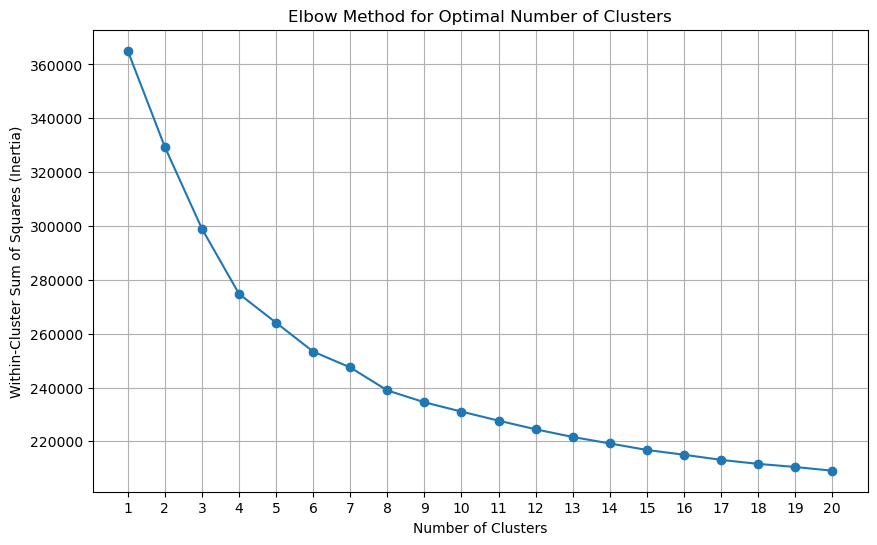

In [10]:
elbow_method(data = new_cust_num, max_clusters = 20)

In [12]:
cluster_kmeans(data = new_cust_num, num_clusters = 8)

c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 513, 2329, 3218,  409, 4806, 4554, 2431, 2868], dtype=int64))


c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_k

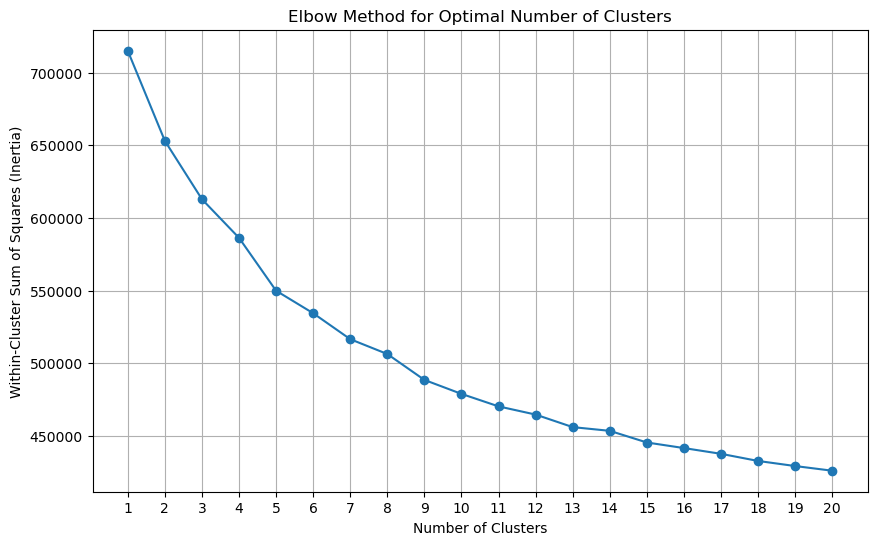

In [16]:
elbow_method(data = new_azdi_num, max_clusters = 20)

In [18]:
cluster_kmeans(data = new_azdi_num, num_clusters = 9)

c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([5705, 1575, 6556, 4341, 5934, 6465, 8023,  134,  822], dtype=int64))


DBSCAN for numeric variables

In [21]:
dbscan_clustering(data = new_cust_num.drop(columns = 'Cluster'), eps = 0.5, min_samples = 20)
# dbscan found 9 with eps = 0.5, n=50 and min_sample = 2
# but 0 when min_sample > 2
# now trying with n = 10 and min_sample = 2 --> 873
# min_sample = 5 --> 34
# min_sample = 10 --> 3
# but most values were not put into a cluster
# eps = 0.8 and min_sample = 20 --> 3
# but still 17500 of 21000 not in a cluster
# I clipped two metric variables to have 99 and 95 percentile as max.
# eps = 0.8, min_sample = 20 --> 8 with 19500 -1. 

Number of clusters found: 0
-1    21128
Name: Cluster, dtype: int64


In [22]:
dbscan_clustering(data = new_azdi_num.drop(columns = 'Cluster'), eps = 0.5, min_samples = 37) 
# dbscan found 1 cluster with eps = 0.5, n=50 and min_sample = 2 
# with n = 10 and min_sample = 2 --> 2107 clusters 
# min_sample = 5 --> 118 
# min_sample = 10 --> 17 
# min_sample = 20 --> 1 
# min_sample = 15 --> 7 
# min_sample = 18 --> 3 
# I think min_sample = 18 is reasonable because the dataset is almost twice the size of customers. 

Number of clusters found: 0
-1    39555
Name: Cluster, dtype: int64


DBSCAN cannot find clusters, so I will use k-means. 

#### Numerical Analysis - Combinded dataset

In [96]:
segment = pd.concat([azdias_num, customers_num], axis = 0, ignore_index = True)
segment.shape
seg_model, seg_model_fit, seg_var_expl = pca_model(data = segment, components = 50)
print(seg_var_expl)
new_seg_num = pd.DataFrame(seg_model.transform(segment))
new_seg_num.shape

[0.1067805  0.18541547 0.24676293 0.3002862  0.3438497  0.38641187
 0.42097127 0.44869053 0.47515157 0.49664343 0.51804535 0.53538227
 0.55200218 0.56730093 0.58153325 0.59318792 0.60437896 0.61502894
 0.62453557 0.63331818 0.64149411 0.6490781  0.65648852 0.66359637
 0.67019486 0.67651139 0.682473   0.68818693 0.69369051 0.69916388
 0.7044239  0.70957918 0.71459226 0.71954891 0.72435412 0.72908109
 0.73357842 0.73799096 0.74234486 0.74647849 0.75054519 0.75452474
 0.7583547  0.76209234 0.76576863 0.76936996 0.77285047 0.77623769
 0.77953715 0.78276366]


(60683, 50)

In [109]:
cluster_kmeans(data = new_seg_num, num_clusters = 9)

c:\Users\TAMM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 7934,  6594,  9195, 10243, 10493,  1315, 10866,  3500,   543],
      dtype=int64))


In [114]:
azdias_clusters = new_seg_num['Cluster'].iloc[0:len(azdias_num)].value_counts().sort_index()
customer_clusters = new_seg_num['Cluster'].iloc[len(azdias_num):].value_counts().sort_index()
all_categories = set(azdias_clusters.index) | set(customer_clusters.index)
azdias_clusters = azdias_clusters.reindex(all_categories, fill_value=0)
customer_clusters = customer_clusters.reindex(all_categories, fill_value=0)

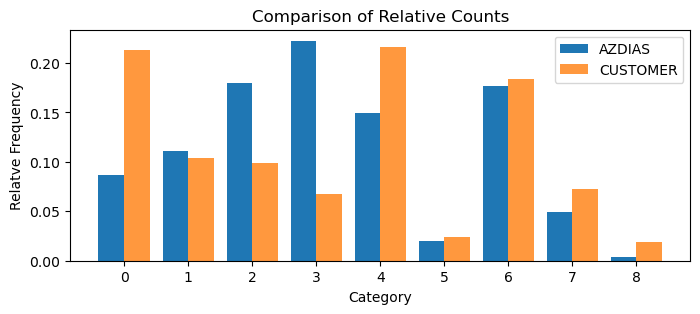

In [188]:
# Figure and bar sizes
fig, ax = plt.subplots(figsize=(8, 3))
bar_width = 0.4

# Calculate the total counts
az_counts = azdias_clusters.sum()
cu_counts = customer_clusters.sum()

# Calculate the relative frequencies
relative_az = azdias_clusters.values / azdias_clusters.sum()
relative_cu = customer_clusters.values / customer_clusters.sum()

# Create bar plots
x_positions = np.arange(len(all_categories))
ax.bar(x_positions - bar_width / 2, relative_az, bar_width, label='AZDIAS')
ax.bar(x_positions + bar_width / 2, relative_cu, bar_width, label='CUSTOMER', alpha=0.8)

# Add labels and title
ax.set_xlabel('Category')
ax.set_ylabel('Relatve Frequency')
ax.set_xticks(np.arange(len(all_categories)))
ax.set_xticklabels(all_categories)
ax.set_title('Comparison of Relative Counts')
ax.legend()


#### Numerical Analysis - Cluster Characteristcs

In [182]:
cc_num = clusters_to_dataset(target_df = customers_num, cluster_df = new_seg_num, cluster_column = 'Cluster', cust = True)
cluster_mean(dataset = cc_num, column = 'D19_SOZIALES', name = 'CUSTOMER_NUM')


(21128, 291)
Cluster
0    0.167718
1    0.235008
2    0.482091
3    0.281794
4    0.208703
5    0.266204
6    0.240828
7    0.304703
8    0.142573
Name: D19_SOZIALES, dtype: float64


In [189]:
cluster_mean(dataset = cc_num, column = 'KBA13_HALTER_40', name = 'CUSTOMER_NUM')

Cluster
0    0.467726
1    0.516568
2    0.520673
3    0.575992
4    0.499912
5    0.564717
6    0.477435
7    0.589539
8    0.519560
Name: KBA13_HALTER_40, dtype: float64


In [166]:
cluster_stats(dataset = cc_num[cc_num['Cluster'] == 0], column = 'D19_SOZIALES', name = 'CUSTOMER_NUM')
cluster_stats(dataset = cc_num[cc_num['Cluster'] == 8], column = 'D19_SOZIALES', name = 'CUSTOMER_NUM')

                      Absolute_Count  Relative_Value
Cluster D19_SOZIALES                                
8       0.0625                   341        0.833741
        0.1875                    15        0.036675
        0.3125                     6        0.014670
        0.4375                    13        0.031785
        0.5625                    14        0.034230
        0.9375                    20        0.048900


In [176]:
az_num = clusters_to_dataset(target_df = azdias_num, cluster_df = new_seg_num, cluster_column = 'Cluster', cust = False)
cluster_mean(dataset = az_num, column = 'D19_SOZIALES', name = 'AZDIAS_NUM')

(39555, 291)
Cluster
0    0.731860
1    0.834504
2    0.913870
3    0.897740
4    0.742854
5    0.867675
6    0.836729
7    0.894473
8    0.619403
Name: D19_SOZIALES, dtype: float64


#### Categorical Analysis - Finding and Plotting Clusters

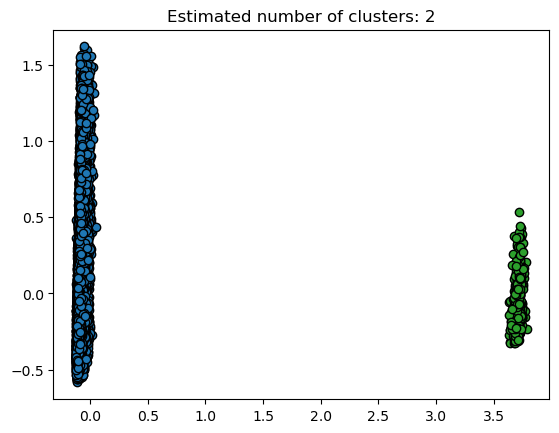

In [30]:

DBSCAN_plotting(data = new_cust_obj, eps = 0.5, min_samples = 5)

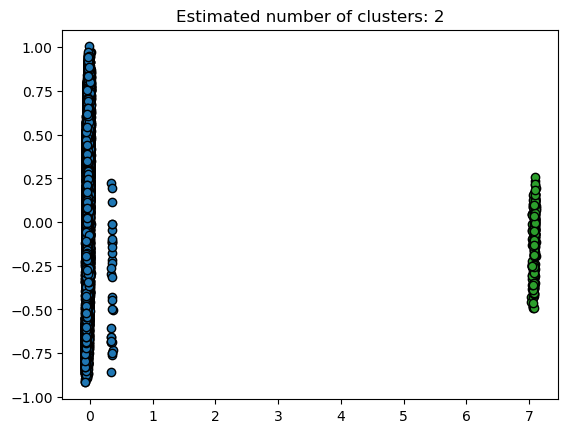

In [12]:
DBSCAN_plotting(data = new_azdi_obj, eps = 0.5, min_samples = 5)

#### Categorical Analysis - Combined dataset

In [207]:

small_azdias = pd.read_csv('data/small_azdias_20k.csv', sep=',')
c_all, c_num, c_cat, c_ord, kba_semio = defining_types(small_azdias)
small_azdias = setting_types(daten = small_azdias)

azdias_num = small_azdias.select_dtypes(include=['float'])
azdias_obj = small_azdias.select_dtypes(include=['object'])
print(' Total:', small_azdias.shape, '\n', 'Numeric:', azdias_num.shape, '\n', 'Categorical:', azdias_obj.shape)

# Importing small customer dataset
small_customers = pd.read_csv('data/small_custom_20k.csv', sep=',')
c_all, c_num, c_cat, c_ord, kba_semio = defining_types(small_customers)
small_customers = setting_types(daten = small_customers)
print(small_customers.shape)

customers_num = small_customers.select_dtypes(include=['float'])
customers_obj = small_customers.select_dtypes(include=['object'])
print(' Total:', small_customers.shape, '\n', 'Numeric:', customers_num.shape, '\n', 'Categorical:', customers_obj.shape)

C:\Users\TAMM\AppData\Local\Temp\ipykernel_10248\781773730.py:1: DtypeWarning: Columns (278) have mixed types. Specify dtype option on import or set low_memory=False.
  small_azdias = pd.read_csv('data/small_azdias_20k.csv', sep=',')


We will remove 0 variables.
set()
 Total: (20000, 341) 
 Numeric: (20000, 291) 
 Categorical: (20000, 50)


C:\Users\TAMM\AppData\Local\Temp\ipykernel_10248\781773730.py:10: DtypeWarning: Columns (172) have mixed types. Specify dtype option on import or set low_memory=False.
  small_customers = pd.read_csv('data/small_custom_20k.csv', sep=',')


We will remove 0 variables.
set()
(20000, 342)
 Total: (20000, 342) 
 Numeric: (20000, 291) 
 Categorical: (20000, 51)


In [208]:
# We merge the dataset to compare the cluster sizes and do mca.

cat = pd.concat([azdias_obj, customers_obj], axis = 0, ignore_index = True )
new_cat, cat_mca_model = mca_model(cat)
new_cat.shape

c:\Users\TAMM\anaconda3\lib\site-packages\prince\mca.py:30: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = pd.get_dummies(X, columns=X.columns)
c:\Users\TAMM\anaconda3\lib\site-packages\prince\mca.py:30: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = pd.get_dummies(X, columns=X.columns)
c:\Users\TAMM\anaconda3\lib\site-packages\prince\mca.py:30: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = pd.get_dummies(X, columns=X.columns)
c:\Users\TAMM\anaconda3\lib\site-packages\prince\mca.py:30: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  one_hot = p

(40000, 2)

0    39425
1      575
Name: Cluster, dtype: int64


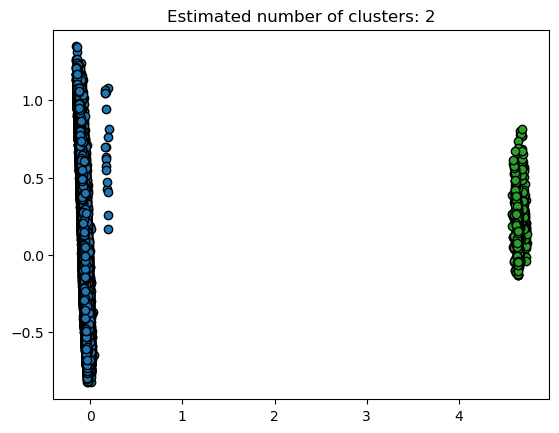

In [209]:
DBSCAN_plotting(data = new_cat, eps = 0.5, min_samples = 5)

In [220]:
print('Population:\n', new_cat['Cluster'].iloc[0:20000].value_counts().sort_index())
print()
print('Customers:\n', new_cat['Cluster'].iloc[20000:].value_counts().sort_index())

Population:
 0    19875
1      125
Name: Cluster, dtype: int64

Customers:
 0    19550
1      450
Name: Cluster, dtype: int64


#### Categorical Analysis - Cluster Characteristcs

Numerical clusters

In [221]:
az_obj = clusters_to_dataset(target_df = azdias_obj, cluster_df = new_cat, cluster_column = 'Cluster', cust = False)
cc_obj = clusters_to_dataset(target_df = customers_obj, cluster_df = new_cat, cluster_column = 'Cluster', cust = True)

(20000, 50)
(20000, 51)


In [222]:


cluster_stats(dataset = az_obj, column = 'D19_KONSUMTYP_MAX', name = 'AZDIAS_OBJ')

                           Absolute_Count  Relative_Value
Cluster D19_KONSUMTYP_MAX                                
0       1                            3501        0.176151
        2                            2233        0.112352
        3                            1437        0.072302
        4                            1833        0.092226
        8                            6328        0.318390
        9                            4543        0.228579
1       1                              31        0.248000
        2                              23        0.184000
        3                              17        0.136000
        4                              10        0.080000
        8                              29        0.232000
        9                              15        0.120000


In [227]:

cluster_stats(dataset = cc_obj, column = 'D19_KONSUMTYP_MAX', name = 'CUSTOMER_OBJ')

                           Absolute_Count  Relative_Value
Cluster D19_KONSUMTYP_MAX                                
0       1                            2718        0.139028
        2                           12427        0.635652
        3                             952        0.048696
        4                            1461        0.074731
        8                            1840        0.094118
        9                             152        0.007775
1       1                              61        0.135556
        2                             233        0.517778
        3                              35        0.077778
        4                              43        0.095556
        8                              72        0.160000
        9                               6        0.013333


In [200]:
for c in cc_obj.columns:
    cluster_stats(dataset = cc_obj, column = c, name = 'CUSTOMER_OBJ')

                      Absolute_Count  Relative_Value
Cluster index  index                                
0       2      23315               1        0.000051
        5      30977               1        0.000051
        25     34197               1        0.000051
        29     29870               1        0.000051
        31     33945               1        0.000051
...                              ...             ...
1       140395 31168               1        0.002222
        140567 32130               1        0.002222
        140653 25465               1        0.002222
        140673 31033               1        0.002222
        140745 37873               1        0.002222

[20000 rows x 2 columns]
                   Absolute_Count  Relative_Value
Cluster ANREDE_KZ                                
0       1                   13018        0.665882
        2                    6532        0.334118
1       1                     288        0.640000
        2                     162  

In [223]:
cluster_stats(dataset = az_obj, column = 'HH_DELTA_FLAG', name = 'AZDIAS')

                       Absolute_Count  Relative_Value
Cluster HH_DELTA_FLAG                                
0       -1.0                      825        0.041509
         0.0                    17361        0.873509
         1.0                     1689        0.084981
1        0.0                       14        0.112000
         1.0                      111        0.888000


In [225]:
cluster_stats(dataset = cc_obj, column = 'HH_DELTA_FLAG', name = 'CUSTOMER')

                       Absolute_Count  Relative_Value
Cluster HH_DELTA_FLAG                                
0       -1.0                     1020        0.052174
         0.0                    16206        0.828951
         1.0                     2324        0.118875
1        0.0                       25        0.055556
         1.0                      425        0.944444


### Part 2: Supervised Learning Model
Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [191]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory= False)

C:\Users\TAMM\AppData\Local\Temp\ipykernel_11960\2624572247.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [ ]:
mailout_train.RESPONSE.mean()
# 1.24% positive answers

In [196]:
# Splitting dataset into train and test
X = mailout_train.drop(columns = 'RESPONSE')
y = mailout_train.RESPONSE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)




In [199]:
X_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
3618,17891,1,1.0,0.0,NaN,NaN,NaN,NaN,10.0,11.0,...,3.0,1.0,1.0,1.0,3.0,9.0,3.0,3,2,3
121,22038,1,1.0,9.0,NaN,NaN,NaN,NaN,9.0,1.0,...,3.0,10.0,7.0,4.0,6.0,9.0,7.0,1,1,4
4577,8175,3,1.0,9.0,NaN,NaN,NaN,NaN,9.0,2.0,...,0.0,9.0,12.0,9.0,6.0,9.0,3.0,1,2,3
16505,43825,1,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,1.0,5.0,2.0,1.0,6.0,9.0,3.0,3,2,4
1148,65488,2,1.0,15.0,NaN,NaN,NaN,NaN,10.0,3.0,...,2.0,1.0,1.0,1.0,4.0,9.0,7.0,3,2,4


### Trail and Error

In [ ]:
"""

#https://towardsdatascience.com/clustering-on-numerical-and-categorical-features-6e0ebcf1cbad


import pandas as pd

# Creating a dictionary with the data
dictionary = {"age": [22, 25, 30, 38, 42, 47, 55, 62, 61, 90], 
              "gender": ["M", "M", "F", "F", "F", "M", "M", "M", "M", "M"], 
              "civil_status": ["SINGLE", "SINGLE", "SINGLE", "MARRIED", "MARRIED", "SINGLE", "MARRIED", "DIVORCED", "MARRIED", "DIVORCED"], 
              "salary": [18000, 23000, 27000, 32000, 34000, 20000, 40000, 42000, 25000, 70000], 
              "has_children": [False, False, False, True, True, False, False, False, False, True], 
              "purchaser_type": ["LOW_PURCHASER", "LOW_PURCHASER", "LOW_PURCHASER", "HEAVY_PURCHASER", "HEAVY_PURCHASER", "LOW_PURCHASER", "MEDIUM_PURCHASER", "MEDIUM_PURCHASER", "MEDIUM_PURCHASER", "LOW_PURCHASER"]}

# Creating a Pandas DataFrame from the dictionary
dataframe = pd.DataFrame.from_dict(dictionary)

distance_matrix = gower.gower_matrix(dataframe)


# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.3, 
                        min_samples=2, 
                        metric="precomputed")

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

# Adding the results to a new column in the dataframe
dataframe["cluster"] = dbscan_cluster.labels_
dataframe["cluster"]

"""

In [ ]:

# this does take too much time. 
#distance_matrix = gower.gower_matrix(new_cust)

In [ ]:
"""
A failed try with random projection 
#target_dimension = customers_num.shape[1] // 2
for n in range(40,330, 20): 
    rp = random_projection.SparseRandomProjection(n_components = n)
    cust_num_new = rp.fit_transform(customers_num)
    print(cust_num_new.shape)
    # Calculate the number of samples and original dimensionality
    num_samples, original_dimension = customers_num.shape

    # Choose the target dimension after random projection
    target_dimension = cust_num_new.shape[1]

    # Calculate the Johnson-Lindenstrauss (JL) bound for the distortion
    JL_bound = np.sqrt(0.1 * original_dimension / target_dimension)
    
    information_lost_percentage = (1 - JL_bound) * 100

    print('with {} features the JL_bound is:'.format(n), JL_bound)
"""

In [ ]:
# I tried to check how much variance is kept when reducing from 51 to 2 for obj and the numbers for the complete dataset. However, I failed.

"""
categorical_column_variances = np.sum(mca.eigenvalues_)

original_numeric_variance = np.sum(my_model.explained_variance_)
combined_reduced_variance = np.sum(my_model.explained_variance_) + categorical_column_variances

# Step 3: Calculate the percentage of variance retained
variance_retained = (combined_reduced_variance / (original_numeric_variance + categorical_column_variances)) * 100

print(f"Percentage of Variance Retained: {variance_retained:.2f}%")




#original_numeric_variance = customers_num.var().sum()
#original_cateorical_variance = customers_obj.var().sum()
#print(original_numeric_variance, original_cateorical_variance)
#new_numeric_variance = new_cust_num.var().sum()
#new_object_variance = new_cust_obj.var().sum()
#print(new_numeric_variance, new_object_variance)

#print(new_numeric_variance/original_numeric_variance)
#categorical_column_variances = mca.eigenvalues_.sum()
#print(categorical_column_variances)

# Step 1: Calculate the total variance of the original numeric dataset
original_numeric_variance = customers_num.var().sum()


# Step 2: Calculate the variance of the original categorical dataset using MCA eigenvalues
mca = MCA()
mca.fit(customers_obj)
categorical_column_variances_original = mca.eigenvalues_.sum()

# Step 3: Calculate the total variance of the combined reduced dataset
combined_reduced_df = pd.concat([new_cust_num, new_cust_obj], axis=1)

# Step 4: Calculate the variance of the reduced categorical dataset using MCA eigenvalues
mca_reduced = MCA()
mca_reduced.fit(new_cust_obj)
categorical_column_variances_reduced = mca_reduced.eigenvalues_.sum()

combined_reduced_variance = reduced_numeric_df.var().sum() + categorical_column_variances_reduced

# Step 5: Calculate the percentage of variance retained
variance_retained = (combined_reduced_variance / (original_numeric_variance + categorical_column_variances_original)) * 100

print(variance_retained)
"""

In [ ]:
"""
cust_model_2, cust_model_fit_2, cust_var_expl_2 = pca_model(data = customers_num, components = 2)
DBSCAN_plotting(data = pd.DataFrame(cust_model_fit_2), eps = 0.5, min_samples = 5)
azdi_model_2, azdi_model_fit_2, azdi_var_expl_2 = pca_model(data = azdias_num, components = 2)
DBSCAN_plotting(data = pd.DataFrame(azdi_model_fit_2), eps = 0.5, min_samples = 5)
"""